In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams.update({'font.size': 14})

In [16]:
'''
NEW PARAM VALUES
'''

# Solve for gapB kcat/KM forward (gng) direction
R = 8.314e-3 # kJ/mol
T = 298 # K
dG_std_glycolytic = 1.2 # kJ/mol in the reverse (glycolytic) direction. Equilibrator EC 1.2.1.13
kcatB_rev = 9.0 # 1/s Nikkel 2023
KMB_rev = 0.78 # mM/L Nikkel 2023
Keq = np.exp(-dG_std_glycolytic / (R * T))

# gapA straight from Nikkel 2023
KMA_fwd = 0.44 # mM
kcatA_fwd = 31.9 # 1/s

# Convert influx to mM/s
cell_weight = 1e-12 # grams
cell_vol = 1e-18 # m^3
fer_uptk = 6.7 # mmol gcdw^-1 h^-1
frac_bPG = 0.24 # Fraction of ferulate that goes to bPG
mass2vol = 1 / 4 # Basan 2015 Fig 1G
cubic_m2liter = 1e-3
hr2sec = 1 / 3600

# Ferulate influx
JF = fer_uptk * frac_bPG * cell_weight * (1 / cell_vol) * hr2sec * cubic_m2liter * mass2vol # mM/s

# Glucose influx
influx_to_GAP = 7.2 # mmol gcdw^-1 h^-1 Kukurgya 2019
JG = influx_to_GAP * cell_weight * (1 / cell_vol) * hr2sec * cubic_m2liter * mass2vol # mM/s

# Estimate efflux
percent_glucose_upper_efflux = 0.34 # JBC paper
percent_glucose_lower_efflux = 0.85 # Nanqing 240508
approx_met_conc = 1 # mM Bennett 2009
kU = JG * percent_glucose_upper_efflux * (1 / approx_met_conc)
kL = JG * percent_glucose_lower_efflux * (1 / approx_met_conc)

# Guessed
kcatB = kcatA_fwd * 1
kcatA_rev = kcatA_fwd * 1

X = 1e-1 # Ratio of fixed concentration products to fixed concentration substrates in the A_fwd direction

# Derived
KMB = (Keq * kcatB * KMB_rev) / kcatB_rev
KMA_rev = (Keq * kcatA_rev * KMA_fwd) / kcatA_fwd
dG_redox = R * T * np.log(X) # kJ/mol. Negative values favor glycolytic direaction of gapA-catalyzed reaction

In [17]:
'''
HELPER FUNCTIONS
'''

def system_rev_A(t, state, A, B, params):
    kcatA_fwd = params["kcatA_fwd"]
    KMA_fwd = params["KMA_fwd"]
    KMA_rev = params["KMA_rev"]
    Keq = params["Keq"]
    dG_redox = params["dG_redox"]
    kcatB = params["kcatB"]
    KMB = params["KMB"]
    kU = params["kU"]
    kL = params["kL"]
    JG = params["JG"]
    JF = params["JF"]
    U, L = state
    JA = rev_mm(A, U, L, kcatA_fwd, KMA_fwd, KMA_rev, Keq, dG_redox)
    JB = irrev_mm(B, L, kcatB, KMB)
    Udot = -JA + JB + JG - kU * U
    Ldot = JA - JB + JF - kL * L

    return (Udot, Ldot)

def system_irrev(t, state, A, B, params):
    kcatA = params["kcatA"]
    kcatB = params["kcatB"]
    KMA = params['KMA']
    KMB = params["KMB"]
    kU = params["kU"]
    kL = params["kL"]
    JG = params["JG"]
    JF = params["JF"]
    U, L = state
    JA = irrev_mm(A, U, kcatA, KMA)
    JB = irrev_mm(B, L, kcatB, KMB)
    Udot = -JA + JB + JG - kU * U
    Ldot = JA - JB + JF - kL * L

    return (Udot, Ldot)

def irrev_mm(E, S, kcat, KM):
    return kcat * E * (S / (KM + S))

def rev_mm(E, S, P, kcat, KS, KP, Keq, dG_redox, R = R, T = T):
    dG_r = P / (S * Keq)
    return (kcat * E) * ((S / KS) / (1 + (S / KS) + (P / KP))) * (1 - (dG_r + dG_redox) / (R * T))

def get_net_flux_rev(U, L, A, B, params):
    kcatA_fwd = params["kcatA_fwd"]
    KMA_fwd = params["KMA_fwd"]
    KMA_rev = params["KMA_rev"]
    Keq = params["Keq"]
    dG_redox = params["dG_redox"]
    kcatB = params["kcatB"]
    KMB = params["KMB"]
    JA = rev_mm(A, U, L, kcatA_fwd, KMA_fwd, KMA_rev, Keq, dG_redox)
    JB = irrev_mm(B, L, kcatB, KMB)
    return JA - JB

def get_net_flux_irrev(U, L, A, B, params):
    kcatA = params["kcatA"]
    kcatB = params["kcatB"]
    KMA = params['KMA']
    KMB = params["KMB"]
    JA = irrev_mm(A, U, kcatA, KMA)
    JB = irrev_mm(B, L, kcatB, KMB)
    return JA - JB

a_range = np.logspace(-4, 0, num=100, base=10)
b_range = a_range
log_a_range = np.log2(a_range)
log_b_range = np.log2(b_range)

def vary_concentrations_simulate(params, get_net_flux, system, a_range=a_range, b_range=b_range):
    nfs = []
    states = []
    init_state = (1, 1)
    t_span = (0, 200)
    method = 'Radau'
    for A in a_range:
        for B in b_range:
            
            # Simulate
            sol = solve_ivp(system, t_span, init_state, method=method, args=(A, B, params))
            U, L = sol.y[0,-1], sol.y[1,-1]
            states.append((U,L))

            # Calculate net flux
            this_nf = get_net_flux(
                U,
                L,
                A,
                B,
                params
            )
            nfs.append(this_nf)

    nfs = np.array(nfs).reshape(a_range.shape[0], b_range.shape[0])

    return states, nfs

def min_delta_A(gflux, fflux, percent_of_fer=0.15, percent_of_gluc=0.66, a_range=a_range, b_range=b_range):
    '''
    Helper fcn to get minimum change in concentration of
    A to switch from steady state growth on one nutrient to 
    ss growth on another.

    Args:
        - gflux: net flux on glucose
        - flux: net flux on ferulate
        - percents_of_x_flux: percent of nutrient uptake that crosses
            gapdh junction
        - a/b_range: Enzyme concentrations

    Returns:
        - Bounds on A and B concentrations in mM
    '''
    _, max_logB = 0, gflux.shape[1]
    logB_lb = np.argwhere(-fflux[0,:] >= (percent_of_fer))[0, 0]

    A_mMs = []
    B_mMs = []
    for i in range(logB_lb, max_logB):
        A_fer = np.argwhere(-fflux[:, i] >= (percent_of_fer))[-1, 0]
        try:
            A_gluc = np.argwhere(gflux[:, i] >= (percent_of_gluc))[0, 0]
        except IndexError:
            continue

        B_mMs.append(b_range[i])
        A_mMs.append((a_range[A_fer], a_range[A_gluc]))

    return A_mMs, B_mMs

In [18]:
'''
Irreversible system
'''

irrev_params = {
    "kcatA": kcatA_fwd,
    "kcatB": kcatB,
    "KMA": KMA_fwd,
    "KMB": KMB,
    "kU":kU,
    "kL":kL,
    "JG":JG,
    "JF":JF,
}

# Glucose as nutrient
irrev_params["JG"] = JG
irrev_params["JF"] = 0 # Glucose is nutrient
states_gluc, nfs_gluc = vary_concentrations_simulate(
    system=system_irrev,
    get_net_flux=get_net_flux_irrev,
    params=irrev_params
)
gluc_abs_flux = abs(nfs_gluc) # Change for each nutrient

# Ferulate is nutrient
irrev_params["JF"] = JF # Ferulate is nutrient
irrev_params["JG"] = 0
states_fer, nfs_fer = vary_concentrations_simulate(
    system=system_irrev,
    get_net_flux=get_net_flux_irrev,
    params=irrev_params
)
fer_abs_flux = abs(nfs_fer) # Change for each nutrient


In [19]:
this_A_bounds, this_B_ranges = min_delta_A(
    nfs_gluc / JG,
    nfs_fer / JF,
    percent_of_fer=0.15,
    percent_of_gluc=0.66
)

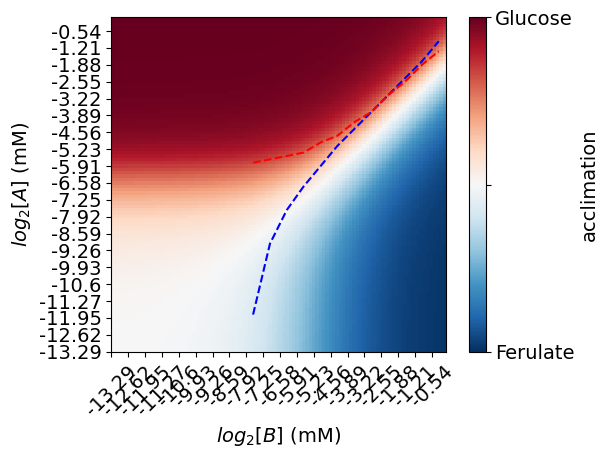

In [20]:
fig, ax = plt.subplots()
ds = 5
extent = (log_b_range[0], log_b_range[-1], log_a_range[0], log_b_range[-1])

# Plot
net_flux = -(gluc_abs_flux / JG) + (fer_abs_flux / JF)
hm = ax.imshow(-net_flux, origin='lower', vmin=-1, vmax=1, cmap='RdBu_r', extent=extent)
cbar = plt.colorbar(hm, ax=ax, label='acclimation', ticks=np.linspace(-1, 1, num=3))
ax.plot(np.log2(this_B_ranges)[::ds], np.log2([ab[0] for ab in this_A_bounds])[::ds], color='blue', linestyle='--', label='Min A for Ferulate')
ax.plot(np.log2(this_B_ranges)[::ds], np.log2([ab[1] for ab in this_A_bounds])[::ds], color='red', linestyle='--', label='Min A for Ferulate')

cbar.ax.set_yticklabels(['Ferulate', '', 'Glucose'])

# Style
ax.set_xticks(log_b_range[::ds])
ax.set_yticks(log_a_range[::ds])
ax.set_xticklabels(np.round(log_b_range[::ds], decimals=2), rotation=45)
ax.set_yticklabels(np.round(log_a_range[::ds], decimals=2))
ax.set_ylabel(r'$log_2 [A]$ (mM)')
ax.set_xlabel(r'$log_2 [B]$ (mM)')
ax.set_ylim(log_a_range[0], log_a_range[-1])
ax.set_xlim(log_b_range[0], log_b_range[-1])
plt.tight_layout()
plt.savefig('figures/irrev_heatmap_boundaries.svg')
plt.show()

Summary figures

In [21]:
Xs = [1e-2, 1e-1, 0.5]
scl_kcats = [0.1, 0.5, 1, 2]
nutrient_fluxes = {} # (X, scl_kcat)
for X in Xs:
    for scl_kcat in scl_kcats:
        dG_redox = R * T * np.log(X)
        kcatB = kcatA_fwd * scl_kcat

        params = {"kcatA_fwd":kcatA_fwd, "KMA_fwd":KMA_fwd, "kcatA_rev":kcatA_rev, "KMA_rev":KMA_rev,
                        "kcatB":kcatB, "KMB":KMB,
                        "kU":kU, "kL":kL,
                        "JG":JG, "JF":JF,
                        "Keq":Keq, "dG_redox":dG_redox}

        # Glucose as nutrient
        params["JG"] = JG
        params["JF"] = 0 # Glucose is nutrient
        states_gluc, nfs_gluc = vary_concentrations_simulate(
            system=system_rev_A,
            get_net_flux=get_net_flux_rev,
            params=params
        )

        # Ferulate is nutrient
        params["JF"] = JF # Ferulate is nutrient
        params["JG"] = 0
        states_fer, nfs_fer = vary_concentrations_simulate(
            system=system_rev_A,
            get_net_flux=get_net_flux_rev,
            params=params
        )

        nutrient_fluxes[(X, scl_kcat)]= (nfs_gluc, nfs_fer)


In [49]:
percent_of_fer = 0.75
percent_of_gluc = 0.75
A_bounds = {}
B_conc_ranges = {}
for X in Xs:
    for scl_kcat in scl_kcats:
        nfs_gluc, nfs_fer = nutrient_fluxes[(X, scl_kcat)]
        this_A_bounds, this_B_ranges = min_delta_A(
            nfs_gluc / JG,
            nfs_fer / JF,
            percent_of_fer=percent_of_fer,
            percent_of_gluc=percent_of_gluc
        )
        A_bounds[(X, scl_kcat)] = this_A_bounds
        B_conc_ranges[(X, scl_kcat)] = this_B_ranges


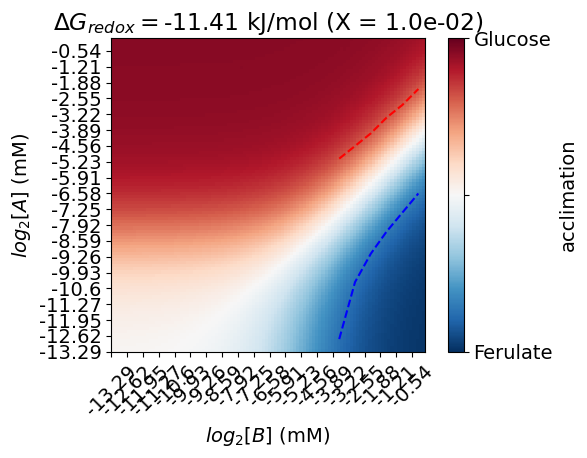

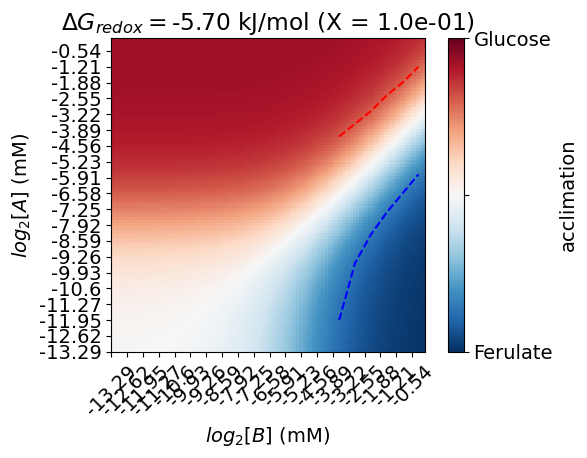

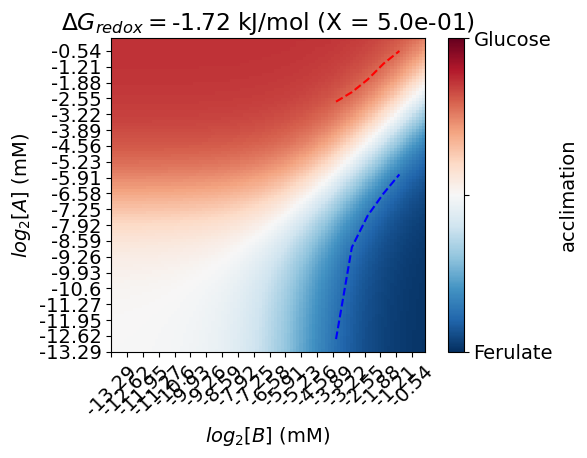

In [50]:
for X in Xs:
    nfs_gluc, nfs_fer = nutrient_fluxes[(X, 1)]
    this_A_bounds = A_bounds[(X, 1)]
    this_B_ranges = B_conc_ranges[(X, 1)]
    fig, ax = plt.subplots()
    ds = 5
    extent = (log_b_range[0], log_b_range[-1], log_a_range[0], log_b_range[-1])
    dG_redox = R * T * np.log(X)

    # Plot
    net_flux = -(abs(nfs_gluc) / JG) + (abs(nfs_fer) / JF)
    hm = ax.imshow(-net_flux, origin='lower', vmin=-1, vmax=1, cmap='RdBu_r', extent=extent)
    cbar = plt.colorbar(hm, ax=ax, label='acclimation', ticks=np.linspace(-1, 1, num=3))
    cbar.ax.set_yticklabels(['Ferulate', '', 'Glucose'])
    ax.plot(np.log2(this_B_ranges)[::ds], np.log2([ab[0] for ab in this_A_bounds])[::ds], color='blue', linestyle='--', label='Min A for Ferulate')
    ax.plot(np.log2(this_B_ranges)[::ds], np.log2([ab[1] for ab in this_A_bounds])[::ds], color='red', linestyle='--', label='Min A for Ferulate')


    # Style
    ax.set_title(r'$\Delta G_{redox} = $' + f'{dG_redox:.2f}' + ' kJ/mol (X = ' + f'{X:.1e}' + ')')
    ax.set_xticks(log_b_range[::ds])
    ax.set_yticks(log_a_range[::ds])
    ax.set_xticklabels(np.round(log_b_range[::ds], decimals=2), rotation=45)
    ax.set_yticklabels(np.round(log_a_range[::ds], decimals=2))
    ax.set_ylabel(r'$log_2 [A]$ (mM)')
    ax.set_xlabel(r'$log_2 [B]$ (mM)')
    ax.set_ylim(log_a_range[0], log_a_range[-1])
    ax.set_xlim(log_b_range[0], log_b_range[-1])
    plt.tight_layout()
    plt.savefig(f"figures/heatmap_dGredox_{dG_redox:.2f}_X_{X:.1e}_frac_JG_{percent_of_gluc}_frac_JF_{percent_of_fer}.tif", dpi=600)
    plt.show()

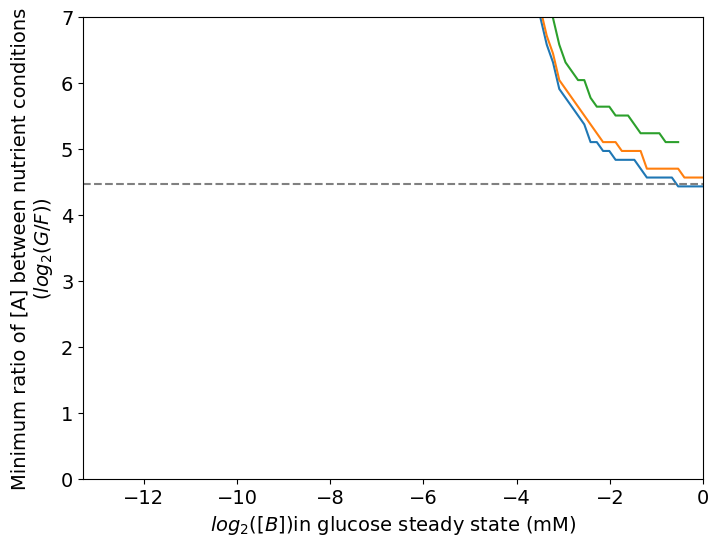

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
xlim = (-13.3, 0)
ylim = (0, 7)
for X in Xs:
    this_A_bounds = A_bounds[(X, 1)]
    this_B_ranges = B_conc_ranges[(X, 1)]
    dG_redox = R * T * np.log(X)
    A_conc_ratios = [ab[1] / ab[0] for ab in this_A_bounds]
    ax.plot(np.log2(this_B_ranges), np.log2(A_conc_ratios), label=r'$\Delta G_{redox} = $' + f'{dG_redox:.2f}' + ' kJ/mol (X = ' + f'{X:.1e}' + ')')

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.hlines(4.459, xlim[0], xlim[1], colors='gray', ls='--', label="Observed")
ax.set_xlabel(r"$log_2([B])$" + "in glucose steady state (mM)")
ax.set_ylabel("Minimum ratio of [A] between nutrient conditions" + "\n" +  r"($log_2(G/F)$)")
# ax.legend()
plt.savefig(f"figures/min_A_ratio_w_dGredox_variation_frac_JG_{percent_of_gluc}_frac_JF_{percent_of_fer}.tif", dpi=600)
plt.show()

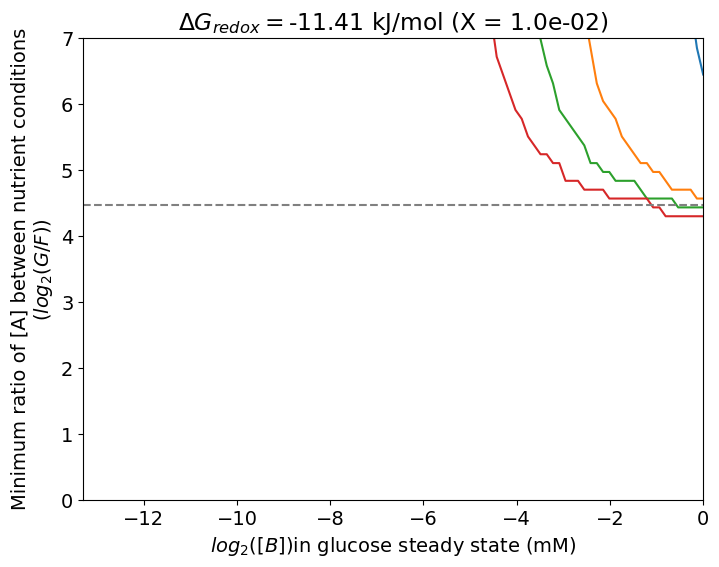

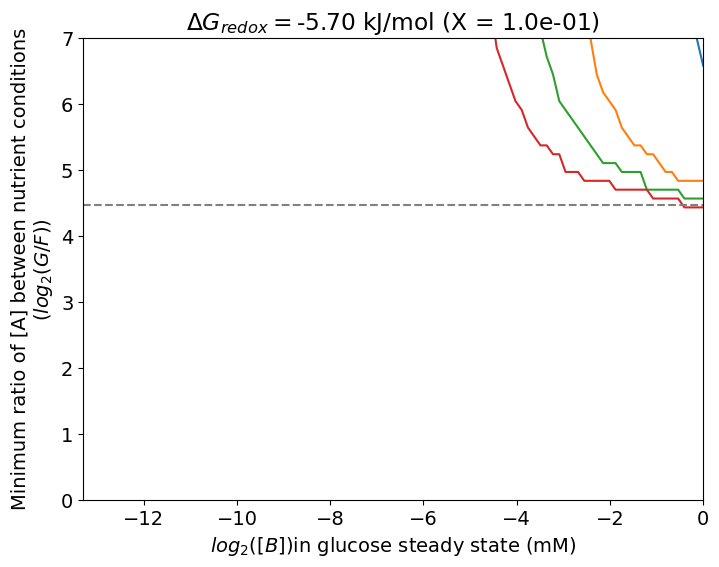

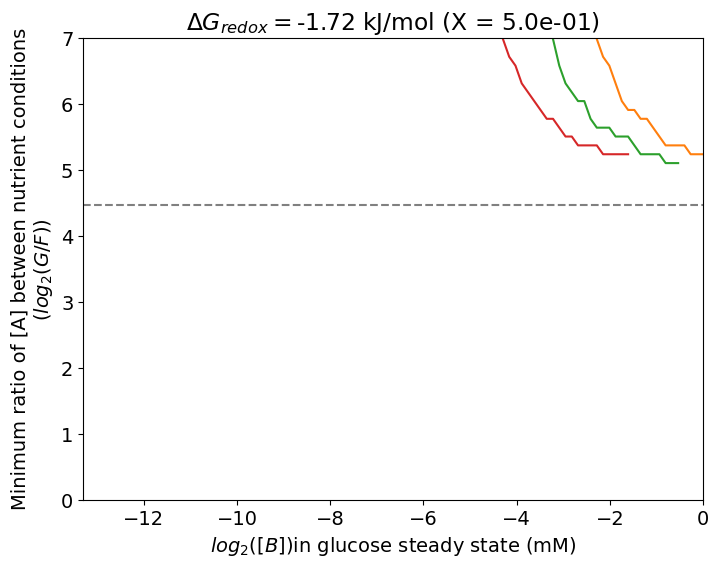

In [52]:
for X in Xs:
    fig, ax = plt.subplots(figsize=(8,6))
    xlim = (-13.3, 0)
    ylim = (0, 7)
    for scl_kcat in scl_kcats:
        this_A_bounds = A_bounds[(X, scl_kcat)]
        this_B_ranges = B_conc_ranges[(X, scl_kcat)]
        dG_redox = R * T * np.log(X)
        A_conc_ratios = [ab[1] / ab[0] for ab in this_A_bounds]
        ax.plot(np.log2(this_B_ranges), np.log2(A_conc_ratios), label=f"kcatB = {scl_kcat:.1f} * kcatA_fwd")

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.hlines(4.459, xlim[0], xlim[1], colors='gray', ls='--', label="Observed")
    ax.set_xlabel(r"$log_2([B])$" + "in glucose steady state (mM)")
    ax.set_ylabel("Minimum ratio of [A] between nutrient conditions" + "\n" +  r"($log_2(G/F)$)")
    ax.set_title(r'$\Delta G_{redox} = $' + f'{dG_redox:.2f}' + ' kJ/mol (X = ' + f'{X:.1e}' + ')')
    # ax.legend()
    plt.savefig(f"figures/min_A_ratio_X_{X}_scl_kcat_{scl_kcat}_frac_JG_{percent_of_gluc}_frac_JF_{percent_of_fer}.tif", dpi=600)
    plt.show()